9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Class weights: {0: 1.0, 1: 1.0}
Epoch 1/50


C:\Users\HP\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


653/653 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.5408 - loss: 0.9231 - val_accuracy: 0.3673 - val_loss: 0.7198 - learning_rate: 0.0010
Epoch 2/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.5736 - loss: 0.6500 - val_accuracy: 0.6187 - val_loss: 0.6767 - learning_rate: 0.0010
Epoch 3/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.5774 - loss: 0.6423 - val_accuracy: 0.6234 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 4/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.5661 - loss: 0.6411 - val_accuracy: 0.5288 - val_loss: 0.7002 - learning_rate: 0.0010
Epoch 5/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.5825 - loss: 0.6387 - val_accuracy: 0.6104 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 6/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.5613 - loss: 0.6455 - val_accuracy: 0.3673 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 7/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.5656 - loss: 0.6442

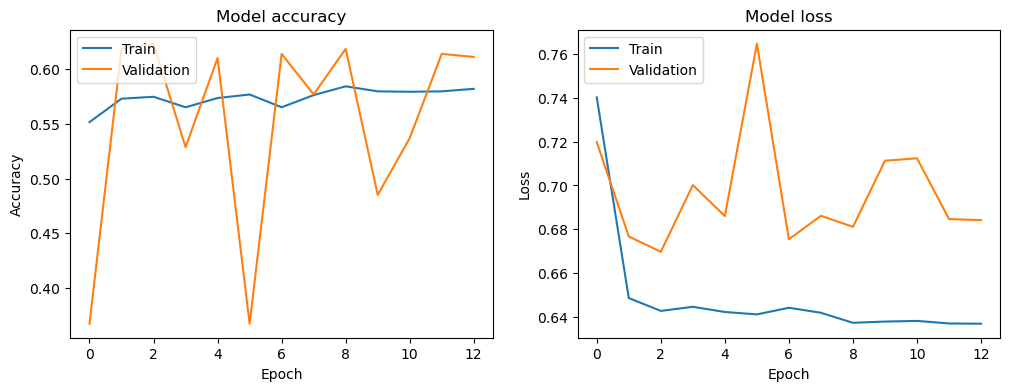

In [3]:
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from PIL import Image
import tensorflow as tf
from imblearn.over_sampling import SMOTE

# Custom Data Generator with SMOTE
class DataGeneratorWithSMOTE(tf.keras.utils.Sequence):
    def __init__(self, image_dir, annot_dir, batch_size=8, input_size=(96, 96), shuffle=True, smote=False):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.smote = smote
        self.image_paths, self.labels = self.load_dataset()
        self.on_epoch_end()

    def load_dataset(self):
        image_paths = []
        labels = []
        for annot_file in os.listdir(self.annot_dir):
            if annot_file.endswith('.xml'):
                tree = ET.parse(os.path.join(self.annot_dir, annot_file))
                root = tree.getroot()
                filename = root.find('filename').text
                image_path = os.path.join(self.image_dir, filename)
                for obj in root.findall('object'):
                    label = obj.find('name').text
                    labels.append(1 if label == 'Motorcycle' else 0)  # Binary labels
                    image_paths.append(image_path)
        return image_paths, labels

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        for img_path in batch_image_paths:
            image = np.array(Image.open(img_path).resize(self.input_size)) / 255.0
            batch_images.append(image)
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)
        
        if self.smote:
            batch_images, batch_labels = self.apply_smote(batch_images, batch_labels)
        
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)

    def apply_smote(self, X, y):
        X_reshaped = X.reshape((X.shape[0], -1))
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_resample(X_reshaped, y)
        X_smote = X_smote.reshape((X_smote.shape[0], *self.input_size, 3))
        return X_smote, y_smote

# Function to load all images and labels for initial SMOTE application
def load_all_images_and_labels(image_dir, annot_dir, input_size=(96, 96)):
    images = []
    labels = []
    for annot_file in os.listdir(annot_dir):
        if annot_file.endswith('.xml'):
            tree = ET.parse(os.path.join(annot_dir, annot_file))
            root = tree.getroot()
            filename = root.find('filename').text
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            if image is not None:  # Check if image is loaded correctly
                image = cv2.resize(image, input_size)  # Resize images if necessary
                for obj in root.findall('object'):
                    label = obj.find('name').text
                    labels.append(1 if label == 'Motorcycle' else 0)  # Binary labels
                    images.append(image)
            else:
                print(f"Warning: Failed to load image {image_path}")
    return np.array(images), np.array(labels)

# Build the Fast R-CNN Model
def build_fast_rcnn_model(input_shape):
    mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in mobilenet.layers:
        layer.trainable = False

    input_image = Input(shape=input_shape)
    features = mobilenet(input_image)
    x = GlobalAveragePooling2D()(features)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)  # 2 classes: object/no-object

    model = Model(inputs=input_image, outputs=output)
    return model

input_shape = (96, 96, 3)
fast_rcnn_model = build_fast_rcnn_model(input_shape)
fast_rcnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fast_rcnn_model.summary()

# Directories
base_dir = 'D:/Users HP/Downloads/cnn'
train_image_dir = os.path.join(base_dir, 'train', 'Images')
train_annot_dir = os.path.join(base_dir, 'train', 'Annotations')
val_image_dir = os.path.join(base_dir, 'val', 'Images')
val_annot_dir = os.path.join(base_dir, 'val', 'Annotations')
test_image_dir = os.path.join(base_dir, 'test', 'Images')
test_annot_dir = os.path.join(base_dir, 'test', 'Annotations')

# Loading datasets and applying SMOTE
X_train, y_train = load_all_images_and_labels(train_image_dir, train_annot_dir, input_size=(96, 96))
X_val, y_val = load_all_images_and_labels(val_image_dir, val_annot_dir, input_size=(96, 96))
X_test, y_test = load_all_images_and_labels(test_image_dir, test_annot_dir, input_size=(96, 96))

# Reshaping data to 2D array for SMOTE
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))

# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reshaped, y_train)

# Reshaping data back to original shape
X_train_balanced = X_train_balanced.reshape((X_train_balanced.shape[0], 96, 96, 3))

# Creating Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_balanced, y_train_balanced, batch_size=8)
val_generator = val_datagen.flow(X_val, y_val, batch_size=8)
test_generator = test_datagen.flow(X_test, y_test, batch_size=8)

# Calculating class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = fast_rcnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluating the model
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_true = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=['Car', 'Motorcycle'])
    return cm, cr

cm, cr = evaluate_model(fast_rcnn_model, test_generator)

print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()